# SET Classification: RelConvNet vs CoRelNet

In [1]:
import sys

import numpy as np
import matplotlib.pyplot as plt
from setGame import *
import tensorflow as tf
from tensorflow.keras import layers, Model
from sklearn.model_selection import train_test_split
sys.path.append('../..'); sys.path.append('../');
import utils

2023-09-14 21:28:35.804540: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-14 21:28:35.855828: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-14 21:28:37.481111: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
setgame = SetGame()

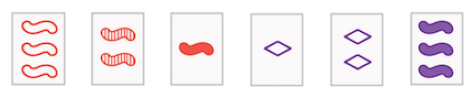

[0 1 5]


In [3]:
num_cards=6
_ = setgame.init_state(num_cards=num_cards, shuffle=False)
hand = setgame.state.dealt_cards
fig, axarr = plt.subplots(1, len(hand), figsize=(len(hand)*1,1))
pi = np.random.choice(range(len(hand)), size=len(hand), replace=False)
for i in range(len(hand)):
    card = hand[i]
    axarr[i].imshow(setgame.image_of_card(card[0], card[1]))
    axarr[i].axis('off')
plt.show()
print(np.sort(np.argsort(pi)[0:3]))


In [227]:
import tensorflow as tf
from tensorflow.keras import layers, Model, Sequential
from sklearn.model_selection import train_test_split

class SetEmbedder():
    def __init__(self, ff_dim1=128, ff_dim2=64):
        img_input = layers.Input(shape=(70, 50, 4))
        x = layers.Conv2D(32, (5, 5), activation='relu')(img_input)
        x = layers.MaxPooling2D((4,4))(x)
        x = layers.Conv2D(32, (5, 5), activation='relu')(x)
        x = layers.MaxPooling2D((4,4))(x)
        x = layers.Flatten()(x)
        x = layers.Dense(ff_dim1, activation='relu')(x)
        x = layers.Dense(ff_dim2, activation='tanh')(x)
        outputs = layers.Dense(12, activation='sigmoid')(x)
        self.model = Model(inputs=img_input, outputs=outputs)
        self.embed = Model(self.model.input, self.model.layers[7].output)
        self.model.summary()
        opt = tf.keras.optimizers.Adam(learning_rate=0.001)
        self.model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['binary_accuracy'])
        self.model_initial_weights = self.model.get_weights()

    def train(self, X_train, y_train, epochs=2):
        self.model.set_weights(self.model_initial_weights)
        self.model.fit(X_train, y_train, epochs=epochs, batch_size=32, verbose=1)

    def predict(self, X_test):
        out = self.model.predict(X_test, verbose=0)
        return out

    def embed(self, X_test):
        out = self.embed(X_test, verbose=0)
        return out

In [228]:
def convert_to_binary(attrs):
    color = {'red':[1,0,0], 'green':[0,1,0], 'purple':[0,0,1]}
    pattern = {'empty':[1,0,0], 'striped':[0,1,0], 'solid':[0,0,1]}
    shape = {'diamond':[1,0,0], 'oval':[0,1,0], 'squiggle':[0,0,1]}
    number = {'one':[1,0,0], 'two':[0,1,0], 'three':[0,0,1]}
    binary_attrs = number[attrs[0]] + color[attrs[1]] + pattern[attrs[2]] + shape[attrs[3]]
    return binary_attrs

n = 1000
X = np.empty((n, 70, 50, 4), dtype=np.float32)
y = np.empty((n, 12), dtype=int)

card_coord = [(i,j) for i in np.arange(9) for j in np.arange(9)]
for i in np.arange(n):
    c = np.random.choice(np.arange(81), size=1)[0]
    (row, col) = card_coord[c]
    attrs = setgame.attributes_of_card(row, col)
    binary_attrs = convert_to_binary(attrs)
    X[i] = setgame.image_of_card(row, col)
    y[i] = binary_attrs


In [229]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
cnn = SetEmbedder(ff_dim1=64, ff_dim2=64)
cnn.train(X_train, y_train, epochs=50)


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 70, 50, 4)]       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 66, 46, 32)        3232      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 16, 11, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 12, 7, 32)         25632     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 3, 1, 32)          0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 96)                0   

In [230]:
for i in range(5):
    j = np.random.choice(range(X_test.shape[0]))
    pred = np.round(cnn.predict(X_test[j:(j+1)]))[0]
    pred = [int(pred[b]) for b in range(len(pred))]
    print(list(pred))
    print(list(y_test[j:(j+1)][0]))
    print('\n')

[0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0]
[0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0]


[0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0]
[0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0]


[1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0]
[1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0]


[0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0]
[0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0]


[0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0]
[0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0]




In [231]:
out = cnn.predict(X_test)
pred = np.array(np.round(out), dtype=int)
1-np.sum(pred != y_test) / (np.prod(pred.shape))


1.0

## SET Classification Task

In [232]:
def create_set_classification_dataset(num_seqs):

    vocab_size = 81
    setgame = SetGame()
    dim = len(cnn.embed(np.expand_dims(setgame.image_of_card(0, 0), axis=0)).numpy().squeeze())

    # generate random features for each object
    card_images = np.zeros((9, 9, dim))
    for i in range(9):
        for j in range(9):
            card_images[i,j] = cnn.embed(np.expand_dims(setgame.image_of_card(i, j), axis=0)).numpy().squeeze()

    object_seqs = np.zeros((num_seqs, 3, dim))
    card_seqs = np.zeros((num_seqs, 3, 2), dtype=int)
    labels = np.zeros(num_seqs, dtype=int)

    for s in np.arange(0, num_seqs, 2):
        _ = setgame.init_state(num_cards=6, shuffle=False)
        hand = setgame.state.dealt_cards
        for i in np.arange(3):
            card = hand[i]
            object_seqs[s, i] = card_images[card[0], card[1]]
            card_seqs[s, i] = [card[0], card[1]]
        labels[s] = 1
        for i in np.arange(3):
            card = hand[i+3]
            object_seqs[s+1, i] = card_images[card[0], card[1]]
            card_seqs[s+1, i] = [card[0], card[1]]
        labels[s+1] = 0

    return card_images, card_seqs, labels, object_seqs,

In [233]:
setgame = SetGame()
X, y, triples = setgame.generate_data()

Total number of triples: 85320
Probability of SET! (in 85320 samples): 0.012658 (1/79=0.012658)


In [234]:
set_triples = [triple for triple, y_ in zip(triples, y) if y_]
X_set = X[y==1]
nonset_triples = [triple for triple, y_ in zip(triples, y) if not y_]
X_nonset = X[y==0]

def train_val_test_split(X, val_size=0.1, test_size=0.2):
    X_train, X_test = train_test_split(X, test_size=test_size)
    X_train, X_val = train_test_split(X_train, test_size=val_size/(1-test_size))
    return X_train, X_val, X_test

set_triples_train, set_triples_val, set_triples_test = train_val_test_split(set_triples, val_size=0.1, test_size=0.2)
nonset_triples_train, nonset_triples_val, nonset_triples_test = train_val_test_split(nonset_triples, val_size=0.1, test_size=0.2)

In [235]:
import itertools

all_cards = [(i,j) for i in range(9) for j in range(9)]

def contains_set(cards):
    return any(setgame.triple_is_set(triple) for triple in itertools.combinations(cards, 3))

def sample_nonset(k):
    idxs = np.random.choice(len(all_cards), k)
    candidate_tuple = [all_cards[i] for i in idxs]
    while contains_set(candidate_tuple):
        idxs = np.random.choice(len(all_cards), k)
        candidate_tuple = [all_cards[i] for i in idxs]
    return candidate_tuple

def sample_set(k, set_triples):
    # sample set triple
    set_cards = set_triples[np.random.choice(len(set_triples))]
    remaining_cards = [card for card in all_cards if card not in set_cards]
    idxs = np.random.choice(len(remaining_cards), k-3, replace=False)
    card_tuple = set_cards + [remaining_cards[i] for i in idxs]
    np.random.shuffle(card_tuple)
    return card_tuple


In [236]:
%timeit sample_nonset(5)

167 µs ± 3.97 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [237]:
%timeit sample_set(5, set_triples=set_triples_train)

37.8 µs ± 276 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [238]:
contains_set(sample_nonset(5))

False

In [239]:
contains_set(sample_set(5, set_triples_train))

True

In [240]:
def create_set_classification_dataset(num_seqs, k, set_triples):

    vocab_size = 81
    setgame = SetGame()
    dim = len(cnn.embed(np.expand_dims(setgame.image_of_card(0, 0), axis=0)).numpy().squeeze())

    # generate random features for each object
    card_images = np.zeros((9, 9, dim))
    for i in range(9):
        for j in range(9):
            card_images[i,j] = cnn.embed(np.expand_dims(setgame.image_of_card(i, j), axis=0)).numpy().squeeze()

    object_seqs = np.zeros((num_seqs, k, dim))
    card_seqs = np.zeros((num_seqs, k, 2), dtype=int)
    labels = np.zeros(num_seqs, dtype=int)

    # sample tuples containing sets
    set_tuples = [sample_set(k, set_triples) for _ in range(num_seqs//2)]
    nonset_tuples = [sample_nonset(k) for _ in range(num_seqs//2)]

    # sample tuples not containing set

    # get card image embedding for each and create object_seqs, card_seqs, etc

    for s in np.arange(0, num_seqs, 2):
        for i in np.arange(k):
            card = set_tuples[s//2][i]
            object_seqs[s, i] = card_images[card[0], card[1]]
            card_seqs[s, i] = [card[0], card[1]]
        labels[s] = 1
        for i in np.arange(k):
            card = nonset_tuples[s//2][i]
            object_seqs[s+1, i] = card_images[card[0], card[1]]
            card_seqs[s+1, i] = [card[0], card[1]]
        labels[s+1] = 0

    return card_images, card_seqs, labels, object_seqs

In [241]:
k = 5
_, _, labels_train, object_seqs_train = create_set_classification_dataset(num_seqs=len(set_triples_train)*24, k=k, set_triples=set_triples_train)
_, _, labels_val, object_seqs_val = create_set_classification_dataset(num_seqs=len(set_triples_val)*24, k=k, set_triples=set_triples_val)
_, _, labels_test, object_seqs_test = create_set_classification_dataset(num_seqs=len(set_triples_test)*24, k=k, set_triples=set_triples_test)

In [242]:
X_train, X_val, X_test = object_seqs_train, object_seqs_val, object_seqs_test
y_train, y_val, y_test = labels_train, labels_val, labels_test

In [243]:
X_train.shape, y_train.shape

((18144, 5, 64), (18144,))

In [244]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, name='binary_crossentropy')
create_opt = lambda : tf.keras.optimizers.Adam()

def create_callbacks():
    callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_acc', restore_best_weights=True, patience=50, start_from_epoch=30)]
    return callbacks

n_epochs = 100

## Transformer

In [245]:
import tensorflow_models as tfm

In [246]:
encoder_kwargs = dict(num_layers=1, num_attention_heads=8, intermediate_size=32,
    activation='relu', dropout_rate=0.0, attention_dropout_rate=0.0,
    use_bias=False, norm_first=True, norm_epsilon=1e-06, intermediate_dropout=0.0)
def create_transformer():
    encoder = tfm.nlp.models.TransformerEncoder(
        **encoder_kwargs)

    model = tf.keras.Sequential([
        encoder,
        tf.keras.layers.GlobalAveragePooling1D(),
        tf.keras.layers.Dense(2)])
    return model

transformer_model = create_transformer()

transformer_model.compile(loss=loss, optimizer=create_opt(), metrics=['acc'])
transformer_model(X_train[:32]); # build
transformer_model.summary()

Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 transformer_encoder_34 (Tr  (32, 5, 64)               20960     
 ansformerEncoder)                                               
                                                                 
 global_average_pooling1d_3  (32, 64)                  0         
 4 (GlobalAveragePooling1D)                                      
                                                                 
 dense_40 (Dense)            (32, 2)                   130       
                                                                 
Total params: 21090 (82.38 KB)
Trainable params: 21090 (82.38 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [247]:
train_size = -1
X_train_ = X_train[:train_size]
y_train_ = y_train[:train_size]
history = transformer_model.fit(X_train_, y_train_, validation_data=(X_val, y_val), epochs=100, verbose=1, callbacks=create_callbacks())

Epoch 1/100
567/567 [==============================] - 6s 5ms/step - loss: 0.6979 - acc: 0.5364 - val_loss: 0.6976 - val_acc: 0.5459
Epoch 2/100
567/567 [==============================] - 3s 5ms/step - loss: 0.6484 - acc: 0.6243 - val_loss: 0.6709 - val_acc: 0.5826
Epoch 3/100
567/567 [==============================] - 3s 5ms/step - loss: 0.6185 - acc: 0.6591 - val_loss: 0.6578 - val_acc: 0.6250
Epoch 4/100
567/567 [==============================] - 3s 5ms/step - loss: 0.5972 - acc: 0.6770 - val_loss: 0.6567 - val_acc: 0.6281
Epoch 5/100
567/567 [==============================] - 3s 5ms/step - loss: 0.5809 - acc: 0.6966 - val_loss: 0.6800 - val_acc: 0.6150
Epoch 6/100
567/567 [==============================] - 3s 5ms/step - loss: 0.5649 - acc: 0.7098 - val_loss: 0.6739 - val_acc: 0.6134
Epoch 7/100
567/567 [==============================] - 3s 5ms/step - loss: 0.5485 - acc: 0.7186 - val_loss: 0.6971 - val_acc: 0.6065
Epoch 8/100
567/567 [==============================] - 3s 5ms/step - 

KeyboardInterrupt: 

In [ ]:
utils.plot_history(history, ('loss', 'acc'));

In [ ]:
transformer_model.evaluate(X_test, y_test, return_dict=True)

81/81 [==============================] - 0s 2ms/step - loss: 2.9267 - acc: 0.5586


{'loss': 2.92673397064209, 'acc': 0.5586419701576233}

## CorelNet

In [248]:
hidden_dense_size = 64
def create_corelnet():
    corelnet = tf.keras.layers.Lambda(lambda x: tf.matmul(x, x, transpose_b=True), name='similarity_matrix')

    model = tf.keras.Sequential(
        [
            corelnet,
            tf.keras.layers.Softmax(axis=-1, name='softmax'),
            tf.keras.layers.Flatten(name='flatten'),
            tf.keras.layers.Dense(hidden_dense_size, activation='relu', name='hidden_dense1'),
            tf.keras.layers.Dense(2, name='output')],
        name='corelnet')
    return model


In [249]:
corelnet_model = create_corelnet()
corelnet_model.compile(loss=loss, optimizer=create_opt(), metrics=['acc'])
corelnet_model(X_train[:32]); # build
corelnet_model.summary()

Model: "corelnet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 similarity_matrix (Lambda)  (32, 5, 5)                0         
                                                                 
 softmax (Softmax)           (32, 5, 5)                0         
                                                                 
 flatten (Flatten)           (32, 25)                  0         
                                                                 
 hidden_dense1 (Dense)       (32, 64)                  1664      
                                                                 
 output (Dense)              (32, 2)                   130       
                                                                 
Total params: 1794 (7.01 KB)
Trainable params: 1794 (7.01 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [250]:
train_size = -1
X_train_ = X_train[:train_size]
y_train_ = y_train[:train_size]
history = corelnet_model.fit(X_train_, y_train_, validation_data=(X_val, y_val), epochs=n_epochs, verbose=1, callbacks=create_callbacks())

Epoch 1/100
567/567 [==============================] - 2s 3ms/step - loss: 0.6667 - acc: 0.5436 - val_loss: 0.6554 - val_acc: 0.5563
Epoch 2/100
567/567 [==============================] - 1s 2ms/step - loss: 0.6502 - acc: 0.5537 - val_loss: 0.6533 - val_acc: 0.5563
Epoch 3/100
567/567 [==============================] - 1s 2ms/step - loss: 0.6498 - acc: 0.5507 - val_loss: 0.6545 - val_acc: 0.5000
Epoch 4/100
567/567 [==============================] - 1s 2ms/step - loss: 0.6500 - acc: 0.5554 - val_loss: 0.6556 - val_acc: 0.5000
Epoch 5/100
567/567 [==============================] - 1s 2ms/step - loss: 0.6497 - acc: 0.5512 - val_loss: 0.6526 - val_acc: 0.5563
Epoch 6/100
567/567 [==============================] - 1s 2ms/step - loss: 0.6484 - acc: 0.5581 - val_loss: 0.6525 - val_acc: 0.5563
Epoch 7/100
567/567 [==============================] - 1s 2ms/step - loss: 0.6485 - acc: 0.5517 - val_loss: 0.6557 - val_acc: 0.5563
Epoch 8/100
567/567 [==============================] - 1s 2ms/step - 

In [201]:
utils.plot_history(history, ('loss', 'acc'));

In [202]:
corelnet_model.evaluate(X_test, y_test)

81/81 [==============================] - 0s 2ms/step - loss: 0.6594 - acc: 0.5556


[0.6594493985176086, 0.5555555820465088]

## CorelNet (no-softmax)

In [203]:
hidden_dense_size = 64
def create_nosoftmax_corelnet():
    corelnet = tf.keras.layers.Lambda(lambda x: tf.matmul(x, x, transpose_b=True), name='similarity_matrix')

    model = tf.keras.Sequential(
        [
            corelnet,
            # tf.keras.layers.Softmax(axis=-1, name='softmax'),
            tf.keras.layers.Flatten(name='flatten'),
            tf.keras.layers.Dense(hidden_dense_size, activation='relu', name='hidden_dense1'),
            tf.keras.layers.Dense(2, name='output')],
        name='corelnet')
    return model


In [204]:
corelnet_nosoftmax_model = create_nosoftmax_corelnet()
corelnet_nosoftmax_model.compile(loss=loss, optimizer=create_opt(), metrics=['acc'])
corelnet_nosoftmax_model(X_train[:32]); # build
corelnet_nosoftmax_model.summary()

Model: "corelnet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 similarity_matrix (Lambda)  (32, 5, 5)                0         
                                                                 
 flatten (Flatten)           (32, 25)                  0         
                                                                 
 hidden_dense1 (Dense)       (32, 64)                  1664      
                                                                 
 output (Dense)              (32, 2)                   130       
                                                                 
Total params: 1794 (7.01 KB)
Trainable params: 1794 (7.01 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [206]:
train_size = -1
X_train_ = X_train[:train_size]
y_train_ = y_train[:train_size]
history = corelnet_nosoftmax_model.fit(X_train_, y_train_, validation_data=(X_val, y_val), epochs=n_epochs, verbose=1, callbacks=create_callbacks())

Epoch 1/100
284/284 [==============================] - 1s 2ms/step - loss: 0.8701 - acc: 0.5749 - val_loss: 0.7698 - val_acc: 0.5949
Epoch 2/100
284/284 [==============================] - 1s 2ms/step - loss: 0.7391 - acc: 0.5997 - val_loss: 0.6884 - val_acc: 0.6034
Epoch 3/100
284/284 [==============================] - 1s 2ms/step - loss: 0.6726 - acc: 0.6188 - val_loss: 0.7774 - val_acc: 0.5818
Epoch 4/100
284/284 [==============================] - 1s 2ms/step - loss: 0.6617 - acc: 0.6203 - val_loss: 0.6653 - val_acc: 0.6265
Epoch 5/100
284/284 [==============================] - 1s 2ms/step - loss: 0.6472 - acc: 0.6331 - val_loss: 0.6539 - val_acc: 0.6096
Epoch 6/100
284/284 [==============================] - 1s 2ms/step - loss: 0.6441 - acc: 0.6330 - val_loss: 0.6565 - val_acc: 0.6235
Epoch 7/100
284/284 [==============================] - 1s 2ms/step - loss: 0.6379 - acc: 0.6427 - val_loss: 0.7028 - val_acc: 0.6103
Epoch 8/100
284/284 [==============================] - 1s 2ms/step - 

In [207]:
utils.plot_history(history, ('loss', 'acc'));

In [208]:
corelnet_nosoftmax_model.evaluate(X_test, y_test)

81/81 [==============================] - 0s 2ms/step - loss: 0.6048 - acc: 0.6516


[0.6048232316970825, 0.6516203880310059]

## PrediNet

In [209]:
from relational_neural_networks.predinet import PrediNet
predinet_kwargs = dict(key_dim=4, n_heads=4, n_relations=16, add_temp_tag=False)
def create_predinet():
    model = tf.keras.Sequential(
        [
            PrediNet(**predinet_kwargs),
            tf.keras.layers.Dense(hidden_dense_size, activation='relu', name='hidden_dense1'),
            tf.keras.layers.Dense(2, name='output')],
        name='predinet')

    return model

In [210]:
predinet_model = create_predinet()
predinet_model.compile(loss=loss, optimizer=create_opt(), metrics=['acc'])
predinet_model(X_train[:32]); # build
predinet_model.summary()

Model: "predinet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 predi_net_2 (PrediNet)      (32, 64)                  11520     
                                                                 
 hidden_dense1 (Dense)       (32, 64)                  4160      
                                                                 
 output (Dense)              (32, 2)                   130       
                                                                 
Total params: 15810 (61.76 KB)
Trainable params: 15810 (61.76 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [211]:
train_size = -1
X_train_ = X_train[:train_size]
y_train_ = y_train[:train_size]
history = predinet_model.fit(X_train_, y_train_, validation_data=(X_val, y_val), epochs=n_epochs, verbose=1, callbacks=create_callbacks())

Epoch 1/100
284/284 [==============================] - 3s 5ms/step - loss: 0.7212 - acc: 0.5164 - val_loss: 0.7105 - val_acc: 0.5231
Epoch 2/100
284/284 [==============================] - 1s 4ms/step - loss: 0.6725 - acc: 0.5830 - val_loss: 0.7187 - val_acc: 0.5046
Epoch 3/100
284/284 [==============================] - 1s 4ms/step - loss: 0.6480 - acc: 0.6223 - val_loss: 0.7395 - val_acc: 0.4954
Epoch 4/100
284/284 [==============================] - 1s 4ms/step - loss: 0.6264 - acc: 0.6422 - val_loss: 0.7605 - val_acc: 0.5069
Epoch 5/100
284/284 [==============================] - 1s 4ms/step - loss: 0.6037 - acc: 0.6706 - val_loss: 0.7729 - val_acc: 0.4892
Epoch 6/100
284/284 [==============================] - 1s 4ms/step - loss: 0.5799 - acc: 0.6941 - val_loss: 0.8031 - val_acc: 0.5239
Epoch 7/100
284/284 [==============================] - 1s 4ms/step - loss: 0.5487 - acc: 0.7151 - val_loss: 0.8124 - val_acc: 0.5247
Epoch 8/100
284/284 [==============================] - 1s 4ms/step - 

In [212]:
utils.plot_history(history, ('loss', 'acc'));

In [213]:
corelnet_nosoftmax_model.evaluate(X_test, y_test)

81/81 [==============================] - 0s 2ms/step - loss: 0.6048 - acc: 0.6516


[0.6048232316970825, 0.6516203880310059]

## RelConvNet

In [224]:
from relational_neural_networks.multi_head_relation import MultiHeadRelation
from relational_neural_networks.relational_graphlet_convolution import RelationalGraphletConvolution


def create_relconvnet():
    relconv_mhr_kwargs = dict(rel_dim=16, proj_dim=4, symmetric=True)
    relconv_kwargs = dict(n_filters=16, graphlet_size=3,
            symmetric_inner_prod=False)
    mhr1 = MultiHeadRelation(**relconv_mhr_kwargs, name='mhr1')
    rel_conv1 = RelationalGraphletConvolution(
        **relconv_kwargs, groups='combinations', name='rgc1')

    model = tf.keras.Sequential([
        mhr1,
        rel_conv1,
            tf.keras.layers.GlobalMaxPooling1D(),
        # tf.keras.layers.Flatten(name='flatten'),
        tf.keras.layers.Dense(hidden_dense_size, activation='relu', name='hidden_dense1'),
        tf.keras.layers.Dense(2, name='output')
        ], name='relconv'
    )

    return model

In [225]:
relconvnet_model = create_relconvnet()
relconvnet_model.compile(loss=loss, optimizer=create_opt(), metrics=['acc'])
relconvnet_model(X_train[:32]); # build
relconvnet_model.summary()

Model: "relconv"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mhr1 (MultiHeadRelation)    (32, 5, 5, 16)            4160      
                                                                 
 rgc1 (RelationalGraphletCo  (32, 10, 16)              2304      
 nvolution)                                                      
                                                                 
 global_max_pooling1d_1 (Gl  (32, 16)                  0         
 obalMaxPooling1D)                                               
                                                                 
 hidden_dense1 (Dense)       (32, 64)                  1088      
                                                                 
 output (Dense)              (32, 2)                   130       
                                                                 
Total params: 7682 (30.01 KB)
Trainable params: 7682 (30.01

In [226]:
train_size = -1
X_train_ = X_train[:train_size]
y_train_ = y_train[:train_size]
history = relconvnet_model.fit(X_train_, y_train_, validation_data=(X_val, y_val), epochs=n_epochs, verbose=1, callbacks=create_callbacks())

Epoch 1/100
284/284 [==============================] - 18s 27ms/step - loss: 0.7389 - acc: 0.5210 - val_loss: 0.7027 - val_acc: 0.5046
Epoch 2/100
284/284 [==============================] - 7s 24ms/step - loss: 0.6823 - acc: 0.5530 - val_loss: 0.6854 - val_acc: 0.5417
Epoch 3/100
284/284 [==============================] - 7s 24ms/step - loss: 0.6641 - acc: 0.5866 - val_loss: 0.6899 - val_acc: 0.5610
Epoch 4/100
284/284 [==============================] - 7s 25ms/step - loss: 0.6387 - acc: 0.6243 - val_loss: 0.6674 - val_acc: 0.5802
Epoch 5/100
284/284 [==============================] - 7s 24ms/step - loss: 0.6135 - acc: 0.6516 - val_loss: 0.6491 - val_acc: 0.6096
Epoch 6/100
284/284 [==============================] - 7s 24ms/step - loss: 0.5803 - acc: 0.6807 - val_loss: 0.6592 - val_acc: 0.6073
Epoch 7/100
284/284 [==============================] - 7s 24ms/step - loss: 0.5612 - acc: 0.6939 - val_loss: 0.6479 - val_acc: 0.6049
Epoch 8/100
284/284 [==============================] - 7s 24m

KeyboardInterrupt: 

In [ ]:
utils.plot_history(history, ('loss', 'acc'));

In [ ]:
relconvnet_model.evaluate(X_test, y_test)

63/63 [==============================] - 0s 3ms/step - loss: 0.2331 - acc: 0.9590


[0.2330666184425354, 0.9589999914169312]

## RelConvNet (agg)

In [221]:
from relational_neural_networks.multi_head_relation import MultiHeadRelation
from relational_neural_networks.relational_graphlet_convolution import RelationalGraphletConvolution

def create_relconvnet_agg():
    relconv_mhr_kwargs = dict(rel_dim=16, proj_dim=4, symmetric=True)
    relconv_kwargs = dict(n_filters=16, graphlet_size=3,
            symmetric_inner_prod=True, permutation_aggregator='max')
    mhr1 = MultiHeadRelation(**relconv_mhr_kwargs, name='mhr1')
    rel_conv1 = RelationalGraphletConvolution(
        **relconv_kwargs, groups='combinations', name='rgc1')

    model = tf.keras.Sequential([
        mhr1,
        rel_conv1,
        tf.keras.layers.GlobalMaxPooling1D(),
        # tf.keras.layers.Flatten(name='flatten'),
        tf.keras.layers.Dense(hidden_dense_size, activation='relu', name='hidden_dense1'),
        tf.keras.layers.Dense(2, name='output')
        ], name='relconv'
    )

    return model

In [222]:
relconvnet_model = create_relconvnet_agg()
relconvnet_model.compile(loss=loss, optimizer=create_opt(), metrics=['acc'])
relconvnet_model(X_train[:32]); # build
relconvnet_model.summary()

Model: "relconv"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mhr1 (MultiHeadRelation)    (32, 5, 5, 16)            4160      
                                                                 
 rgc1 (RelationalGraphletCo  (32, 10, 16)              2304      
 nvolution)                                                      
                                                                 
 global_max_pooling1d (Glob  (32, 16)                  0         
 alMaxPooling1D)                                                 
                                                                 
 flatten (Flatten)           (32, 16)                  0         
                                                                 
 hidden_dense1 (Dense)       (32, 64)                  1088      
                                                                 
 output (Dense)              (32, 2)                   130 

In [223]:
train_size = -1
X_train_ = X_train[:train_size]
y_train_ = y_train[:train_size]
history = relconvnet_model.fit(X_train_, y_train_, validation_data=(X_val, y_val), epochs=n_epochs, verbose=1, callbacks=create_callbacks())

Epoch 1/100
284/284 [==============================] - 73s 142ms/step - loss: 0.7025 - acc: 0.5574 - val_loss: 0.6710 - val_acc: 0.5787
Epoch 2/100
284/284 [==============================] - 36s 128ms/step - loss: 0.6452 - acc: 0.6175 - val_loss: 0.6687 - val_acc: 0.6003
Epoch 3/100
284/284 [==============================] - 36s 128ms/step - loss: 0.6069 - acc: 0.6537 - val_loss: 0.6774 - val_acc: 0.6019
Epoch 4/100
284/284 [==============================] - 36s 127ms/step - loss: 0.5796 - acc: 0.6727 - val_loss: 0.6291 - val_acc: 0.6312
Epoch 5/100
284/284 [==============================] - 37s 129ms/step - loss: 0.5517 - acc: 0.7026 - val_loss: 0.6454 - val_acc: 0.6127
Epoch 6/100
284/284 [==============================] - 36s 128ms/step - loss: 0.5358 - acc: 0.7112 - val_loss: 0.6594 - val_acc: 0.6319
Epoch 7/100
284/284 [==============================] - 36s 127ms/step - loss: 0.5126 - acc: 0.7288 - val_loss: 0.6601 - val_acc: 0.6281
Epoch 8/100
284/284 [===========================

KeyboardInterrupt: 

In [42]:
utils.plot_history(history, ('loss', 'acc'));

In [43]:
relconvnet_model.evaluate(X_test, y_test)

63/63 [==============================] - 0s 3ms/step - loss: 0.1179 - acc: 0.9805


[0.11788409948348999, 0.9804999828338623]

## Learning Curves

In [44]:
from tqdm import tqdm, trange

In [45]:
def create_callbacks(use_wandb=False):
    callbacks = []
    callbacks.append(
        tf.keras.callbacks.EarlyStopping(
            monitor='val_acc', restore_best_weights=True, patience=50, start_from_epoch=30)
            )
    if use_wandb: callbacks.append(wandb.keras.WandbMetricsLogger(log_freq='epoch'))
    return callbacks

def evaluate_model(model, X_test, y_test):
    eval_dict = model.evaluate(X_test, y_test, return_dict=True, verbose=False)
    return eval_dict

def log_to_wandb(evaluation_dict):
    wandb.log(evaluation_dict)

In [46]:
start_trial = 0
wandb_project_name = 'set_classification'

fit_kwargs = {'epochs': 100, 'batch_size': 256}

def evaluate_learning_curves(
    create_model, group_name,
    X_train, y_train, X_val, y_val, X_test, y_test,
    train_sizes, num_trials, use_wandb=False):

    eval_dicts =[]

    for train_size in tqdm(train_sizes, desc='train size'):

        for trial in trange(start_trial, start_trial + num_trials, desc='trial', leave=False):

            if use_wandb:
                run = wandb.init(project=wandb_project_name, group=group_name, name=f'train size = {train_size}; trial = {trial}',
                    config={'train size': train_size, 'trial': trial, 'group': group_name})
            model = create_model()

            sample_idx = np.random.choice(len(X_train), train_size, replace=False)
            X_train_ = X_train[sample_idx]
            y_train_ = y_train[sample_idx]

            history = model.fit(X_train_, y_train_, validation_data=(X_val, y_val), verbose=0,
                callbacks=create_callbacks(use_wandb=use_wandb), **fit_kwargs)

            eval_dict = evaluate_model(model, X_test, y_test)

            if use_wandb:
                log_to_wandb(eval_dict)
                wandb.finish(quiet=True)

            eval_dict.update({'group': group_name, 'train_size': train_size, 'trial': trial})
            eval_dicts.append(eval_dict)

            del model

    return eval_dicts


In [47]:
def create_transformer_model():
    transformer_model = create_transformer()
    transformer_model.compile(loss=loss, optimizer=create_opt(), metrics=['acc'])
    transformer_model(X_train[:32]); # build
    return transformer_model

def create_corelnet_model():
    corelnet_model = create_corelnet()
    corelnet_model.compile(loss=loss, optimizer=create_opt(), metrics=['acc'])
    corelnet_model(X_train[:32]); # build
    return corelnet_model

def create_nosoftmax_corelnet_model():
    corelnet_model = create_nosoftmax_corelnet()
    corelnet_model.compile(loss=loss, optimizer=create_opt(), metrics=['acc'])
    corelnet_model(X_train[:32]); # build
    return corelnet_model

def create_predinet_model():
    predinet_model = create_predinet()
    predinet_model.compile(loss=loss, optimizer=create_opt(), metrics=['acc'])
    predinet_model(X_train[:32]); # build
    return predinet_model

def create_relconvnet_model():
    relconvnet_model = create_relconvnet()
    relconvnet_model.compile(loss=loss, optimizer=create_opt(), metrics=['acc'])
    relconvnet_model(X_train[:32]); # build
    return relconvnet_model

def create_relconvnet_agg_model():
    relconvnet_model = create_relconvet_agg()
    relconvnet_model.compile(loss=loss, optimizer=create_opt(), metrics=['acc'])
    relconvnet_model(X_train[:32]); # build
    return relconvnet_model


In [48]:
num_trials = 5
train_sizes = [500, 1000, 2000, 3000, 4000, 5000]

model_creators = dict(transformer=create_transformer_model, corelnet=create_corelnet_model,
    corelnet_nsoftmax=create_nosoftmax_corelnet_model, predinet=create_predinet_model,
    relconvnet=create_relconvnet_model, relconvnet_agg=create_relconvnet_agg_model)

model_eval_dicts = []
for model_name, model_creator in model_creators.items():
    print(f'evaluating learning curves for {model_name}')
    model_eval_dict = evaluate_learning_curves(
        model_creator, model_name,
        X_train, y_train, X_val, y_val, X_test, y_test,
        train_sizes, num_trials, use_wandb=False)
    model_eval_dicts.append(model_eval_dict)

evaluating learning curves for transformer


train size: 100%|██████████| 6/6 [05:30<00:00, 55.15s/it]


evaluating learning curves for corelnet


train size:  83%|████████▎ | 5/6 [02:39<00:31, 31.86s/it]


KeyboardInterrupt: 

In [ ]:
import pandas as pd
dfs = [pd.DataFrame(eval_dict) for eval_dict in model_eval_dicts]
learning_curves_df = pd.concat(dfs)
learning_curves_df

,loss,acc,group,train_size,trial
0,0.727094,0.7670,transformer,500,0
0,0.693149,0.5005,corelnet,500,0
0,0.231487,0.9255,corelnet_nsoftmax,500,0
0,1.092715,0.6085,predinet,500,0
0,0.676435,0.8440,relconvnet,500,0


In [ ]:
import datetime
datetimestr = datetime.datetime.now().strftime("%Y-%m-%d-%H%M")
learning_curves_df.to_csv(f'learning_curves_data_{datetimestr}.csv')

In [ ]:
import seaborn as sns

sns.lineplot(learning_curves_df, y='acc', x='train_size', hue='group', estimator='mean', errorbar=('ci', 95), legend=True)
# ax.set_title(task_label_map.get(task, task))

/diskarray/home/awni/.conda/envs/relconvnet/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/diskarray/home/awni/.conda/envs/relconvnet/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/diskarray/home/awni/.conda/envs/relconvnet/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/diskarray/home/awni/.conda/envs/relconvnet/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is depr

<Axes: xlabel='epoch', ylabel='acc'>